# CDK2 protein: 30x4 Cross Validation
## Data load and preprocessing

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [33]:
%run ./1_Helper_functions.ipynb

In [34]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

R_a = round(y.sum() / len(y), 4)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(3466, 402)
415
Ra = 0.1197


## Estimators
### ML Classifiers

In [35]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [36]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [37]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [38]:
# ML Classifier
ml_classifiers = {
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [39]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [40]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [41]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': R_a, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# 30x4 CV evaluation

In [42]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

In [43]:
%run ./1_Helper_functions.ipynb


The following procedure performs a P number of assays of K-fold CV.
To track which instances where used for training and testing the `nk_rep_cross_validation()` function also returns the predictions of each model and the split sets, in order to identify which observations were correctly predicted.

- y_preds:
    - Contains the PxK predictions of each method
- splits
    - List that contains PxK tuples with two elements: The train and test indexes.

In [44]:
%%time

n_repeats = 30
n_splits = 4

# **********************
# Perform the evaluation
# **********************
evaluation_name=f'{n_repeats}x{n_splits}cv'
cv30x4, y_preds, splits = nk_rep_cross_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_repeats=n_repeats, n_splits=n_splits,
    y_preds_return=True,
    random_state=42)

# Rename columns 
full_names = ['LR', 'GBT', 'DClf', 'csAVG', 'csMAX', 'csMIN']
new_names = dict(zip(
    [*cv30x4.columns],
    full_names))
cv30x4 = cv30x4.rename(columns=new_names)

# ***************************
# Drop 1NN and csVOTE methods
# ***************************
# cv30x4 = cv30x4.drop(['1-NN', 'csVOTE'], axis=1) # Ommited from the begining
# Update Full names list
full_names = ['LR', 'GBT', 'DClf', 'csAVG', 'csMAX', 'csMIN']

# **********************************
# Extract the individual predictions
# **********************************
# y_preds: Model predictions
# get the test indices
test_sets_idxs = [i[1] for i in splits]

File loaded: ./cachedir/30x4cv_cdk2
CPU times: user 89.5 ms, sys: 12.1 ms, total: 102 ms
Wall time: 113 ms


In [45]:
%run Friedman_and_Nemenyi_test.ipynb
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Friedman Test

In [46]:
cv30x4.to_csv(f'cv30x4_{protein_name}.csv')

In [47]:
# ROC-AUC
metric_name='roc_auc'

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))

display(friedmanTest(cv30x4.loc[metric_name]))

df_R = order_df(cv30x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(
                            X, y, metrics[metric_name], 
                            n_reps=30, test_size=0.5, 
                            random_state=42)


         LR       GBT      DClf     csAVG     csMAX     csMIN
0  0.987236  0.971232  0.980628  0.977703  0.983339  0.963891
1  0.322538  0.011268  0.081464  0.043602  0.145138  0.002632


,LR,GBT,DClf,csAVG,csMAX,csMIN
Normality,1,0,1,0,1,0


,statistic,p
Bartlett,131.615845,1.080499e-26


,chi^2,dof,p_value
Friedman Test,580.9,5,2.706322e-123


## Repeated Measures ANOVA 

In [48]:
%%R -i df_R

# One way anova using R
library(dplyr)
library(tidyr)
# library(emmeans)

df = df_R
df_melt <- df %>%
    mutate(rep = factor(1:nrow(.))) %>%
    pivot_longer(cols=c(everything(), -rep), 
                 names_to='method', 
                 values_to='score')

anova <- aov(score ~ method + rep, data=df_melt)
print(summary(anova))

             Df Sum Sq Mean Sq   F value Pr(>F)    
method        5 17.358   3.472 10042.644 <2e-16 ***
rep         119  0.185   0.002     4.504 <2e-16 ***
Residuals   595  0.206   0.000                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### post-hoc ANOVA

In [49]:
%%R -i df_R

# One way anova using R
library(dplyr)
# library(ggpubr)
# library(rstatix)

df = df_R
df_melt <- df %>%
    mutate(rep = factor(1:nrow(.))) %>%
    pivot_longer(cols=c(everything(), -rep), 
                 names_to='method', 
                 values_to='score')

df_melt %>%
    group_by(method) %>%
    shapirto_test()

anova <- anova_test(data=df, dv=score, wid=rep, within=method)
anova

R[write to console]: Error in shapirto_test(.) : 
  no se pudo encontrar la función "shapirto_test"

R[write to console]: Además: 
R[write to console]: There were 15 warnings (use warnings() to see them)
R[write to console]: 




Error in shapirto_test(.) : 
  no se pudo encontrar la función "shapirto_test"


## AUC-ROC

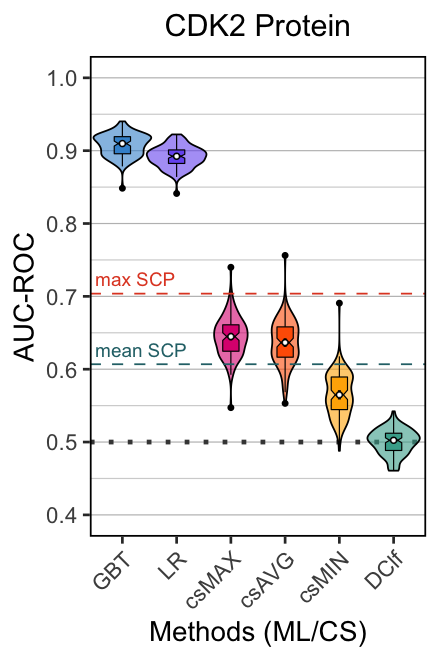

In [50]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.4, y_max=1,
              dot_size=4, scale='area', violin_width=1.1) +
add_ref_values('mean SCP', single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('CDK2 Protein')

# Save the picture
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

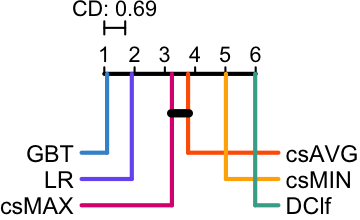

In [51]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
# plotCD_color(df_R, alpha=0.05, cex=.8, labels.cex=0.48, colPalette=cbbPalette, side_marging=12)
plotCD_color(df_R, alpha=0.05, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)
dev.off()

plotCD_color(df_R, alpha=0.05, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)


R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths


R[write to console]: PMCMR is superseded by PMCMRplus and will be no longer maintained. You may wish to install PMCMRplus instead.



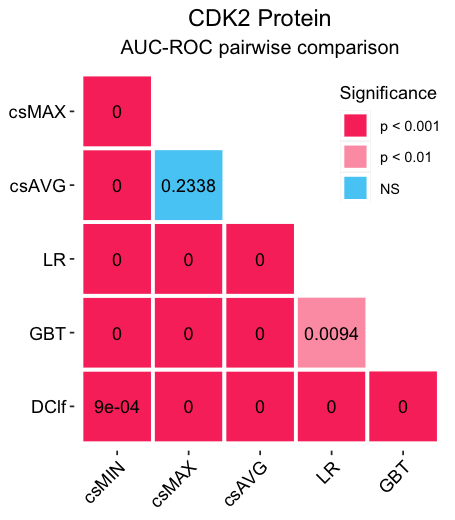

In [52]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

p = plot_p_vals_heatmap(df_R) +
labs(title='CDK2 Protein', subtitle="AUC-ROC pairwise comparison")

# Save the picture
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
ggsave(filename, plot=p, width=3.5, height= 4)
p

## pAUC-ROC Normalized

In [53]:
# Random value given n_a and N
test_size=0.25
N = y.size*0.25
n_a = y.sum()*0.25
print(N, n_a)
pROC_base_random = pROC_auc_rand(N, n_a, normalized=True)
print('Max pACU-ROC (non-normalized):', 1/N)
pROC_base_random

866.5 103.75
Max pACU-ROC (non-normalized): 0.001154068090017311


0.14766080669711348

In [54]:
# ROC-AUC
metric_name='pROC'

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))
# Friedman test
display(friedmanTest(cv30x4.loc[metric_name]))

df_R = order_df(cv30x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
# single_mean, single_max = n_hold_out_single_performance(X, y, 
#                             metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

         LR       GBT      DClf     csAVG     csMAX     csMIN
0  0.991257  0.988269  0.964246  0.975923  0.981244  0.972877
1  0.650693  0.392985  0.002817  0.029888  0.092935  0.015805


,LR,GBT,DClf,csAVG,csMAX,csMIN
Normality,1,1,0,0,1,0


,statistic,p
Bartlett,141.622093,8.087893e-29


,chi^2,dof,p_value
Friedman Test,596.17619,5,1.355344e-126


In [55]:
%%R -i full_names -i df_R -i single_mean -i single_max -ipROC_base_random -w 6 -h 4 --units in -r 200
source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1., 
#                dot_size=7, bin_width=0.002,
#                y_label='AUC-pROC', base_h_line=pROC_base_random) +
# add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
# add_ref_values('Sing. conf. max', single_max, color='coral1')

In [56]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
# plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

In [57]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

# plot_p_vals_heatmap(df_R)

## EF 12% = Ra

In [58]:
# ROC-AUC
metric_name='nef_12_Ra'

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))
# Friedman test
display(friedmanTest(cv30x4.loc[metric_name]))

df_R = order_df(cv30x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

         LR       GBT      DClf     csAVG     csMAX     csMIN
0  0.990664  0.965446  0.973720  0.961613  0.983631  0.983100
1  0.594895  0.003554  0.018826  0.001708  0.154368  0.137971


,LR,GBT,DClf,csAVG,csMAX,csMIN
Normality,1,0,0,0,1,1


,statistic,p
Bartlett,9.920087,0.077531


,chi^2,dof,p_value
Friedman Test,588.595238,5,5.887401e-125


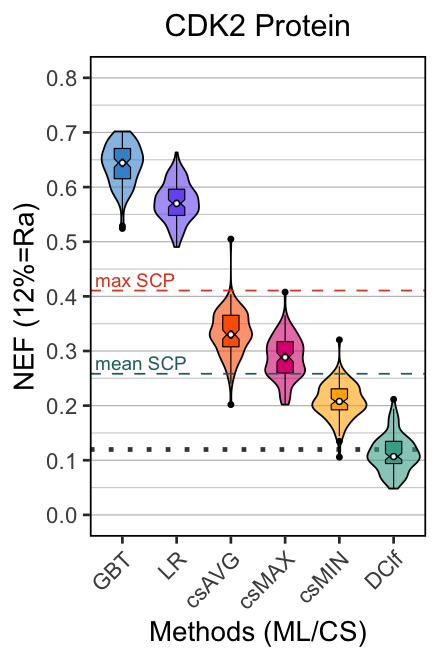

In [59]:
%%R -i full_names -i df_R -i R_a -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.0, y_max=0.8,
              dot_size=4, scale='area', violin_width=1., base_h_line=R_a,
               y_label='NEF (12%=Ra)') +
add_ref_values('mean SCP', single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('CDK2 Protein')

# Save the picture
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

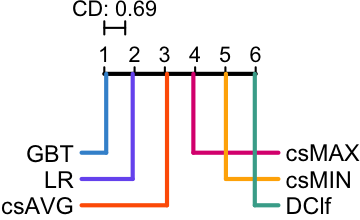

In [60]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
plotCD_color(df_R, alpha=0.05, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)
dev.off()

plotCD_color(df_R, alpha=0.05, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)

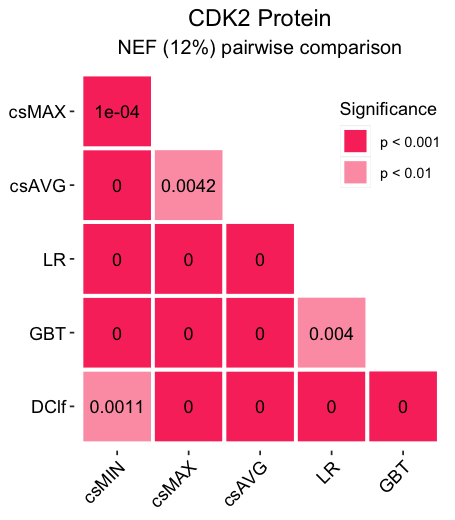

In [61]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

p = plot_p_vals_heatmap(df_R) +
labs(title='CDK2 Protein', subtitle="NEF (12%) pairwise comparison")

# Save the picture
protein_name <- 'cdk2'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
ggsave(filename, plot=p, width=3.5, height= 4)
p

# Y-randomization test

In [62]:
%%time 

n_repeats = 10
n_splits = 4

chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
chi_results = {}
evaluation_name = f'y_scrambling_reps_{n_repeats}x{n_splits}CV'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = nk_rep_cross_validation_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_repeats=n_repeats, n_splits=n_splits,
                             y_preds_return=True)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

File loaded: ./cachedir/y_scrambling_reps_10x4CV_cdk2_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_cdk2_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_cdk2_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_cdk2_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_cdk2_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 23.3 ms, sys: 7.28 ms, total: 30.5 ms
Wall time: 31.4 ms


## AUC-ROC

In [63]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

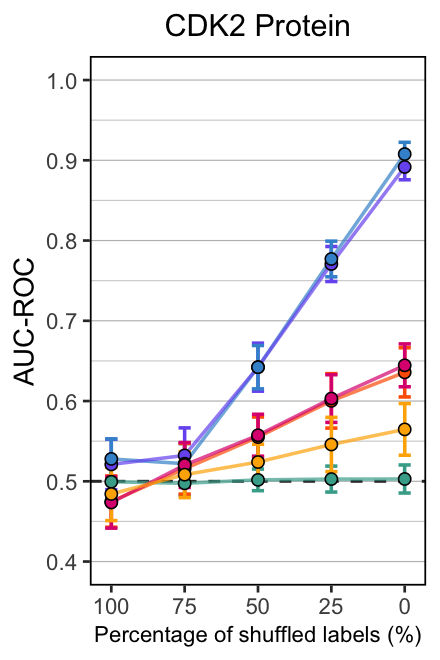

In [64]:
%%R -i df_y_random -i full_names -i df_R -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=1.8, line_size=0.6, 
           error_size=0.6, error_dodge=0.05, error_width=25) +
ggtitle('CDK2 Protein')

# Save the picture
protein_name <- 'cdk2'
methodology <- 'y-scramb-10x4CV'
metric <- 'AUC-ROC'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

## AUC-pROC Normalized

In [65]:
df_y_random = get_group_stats(chi_results, metric_name='pROC')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

In [66]:
%%R -i df_y_random -i df_R -i pROC_base_random -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

# plot_lines(df_y_random, cbbPalette, y_min=0.0, y_max=1., 
#                y_label='AUC-pROC', base_h_line=pROC_base_random)

## EF 12% 

In [67]:
df_y_random = get_group_stats(chi_results, metric_name='nef_12_Ra')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

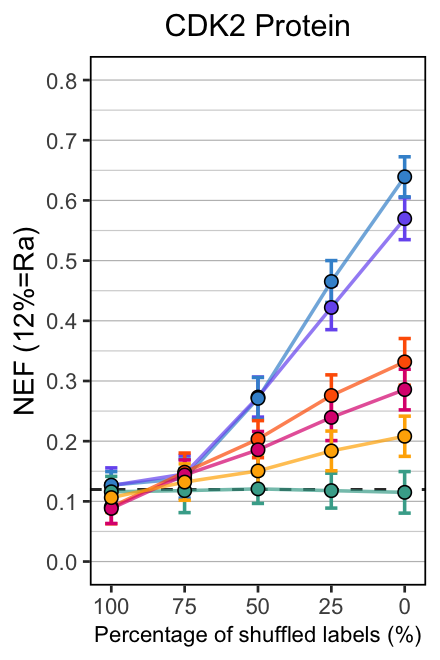

In [68]:
%%R -i df_y_random -i full_names -i df_R -i R_a -w 2.2 -h 3.3 --units in -r 200
 
source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=2., line_size=0.6,
           error_size=0.6, error_dodge=0.05, error_width=25,
           y_min=0, y_max=0.8, base_h_line=R_a, y_label='NEF (12%=Ra)') +
ggtitle('CDK2 Protein')

# Save the picture
protein_name <- 'cdk2'
methodology <- 'y-scramb-10x4CV'
metric <- 'NEF'
filename <- paste0('images/cdk2/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p